# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

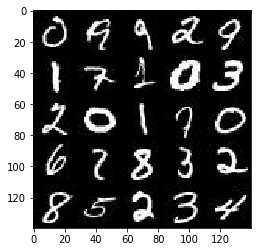

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

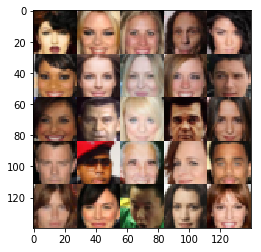

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    read_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_img = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32,())
    return (read_input_img, z_img, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # input image is 28x28x3
    with(tf.variable_scope('discriminator', reuse = reuse)):
        # input image is 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        
        # image is 14x14x64
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * layer2_bn, layer2_bn)
        
        # image is 7x7x128
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        layer3_bn = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * layer3_bn, layer3_bn)
        
        # image is 4x4x256        
        # flatten data
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with(tf.variable_scope('generator', reuse = not is_train)):
        # random vector of dimensions z
        layer1_dense = tf.layers.dense(z, 7*7*512)
        # reshape so we can start to convolution
        image_ = tf.reshape(layer1_dense, (-1, 7, 7, 512))
        layer1_bn = tf.layers.batch_normalization(image_, training=is_train)
        layer1_lrl = tf.maximum(alpha * layer1_bn, layer1_bn)
        
        # image is 7x7x512
        layer2_conv2d_t = tf.layers.conv2d_transpose(layer1_lrl, 256, 5, strides=2, padding='same')
        layer2_bn = tf.layers.batch_normalization(layer2_conv2d_t, training=is_train)
        layer2_lrl = tf.maximum(alpha * layer2_bn, layer2_bn)
        
        # image is 14x14x256
        logits = tf.layers.conv2d_transpose(layer2_lrl, out_channel_dim, 5, strides=2, padding='same')
        
        # image is 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    real_label_smoothing = tf.ones_like(d_logits_real) * (1 - 0.1)    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels = real_label_smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels = tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels = tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with(tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS))):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, z_data, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    
    d_loss, g_loss = model_loss(images, z_data, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_images_every_batch = 200
    print_loss_every_batch = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {images: batch_images, z_data : batch_z})
                _ = sess.run(g_opt, feed_dict = {images: batch_images, z_data : batch_z})
                _ = sess.run(g_opt, feed_dict = {images: batch_images, z_data : batch_z})
                
                if(step % print_loss_every_batch) == 0:
                    train_loss_d = d_loss.eval({images : batch_images, z_data : batch_z})
                    train_loss_g = g_loss.eval({images : batch_images, z_data : batch_z})
                    print('Epoch: ' +str(epoch_i)+ ' - Discriminator Loss: ' + str(train_loss_d) + ' ..... Generator Loss: ' + str(train_loss_g))
                    
                
                if(step % print_images_every_batch) == 0:
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 - Discriminator Loss: 2.39482 ..... Generator Loss: 0.182298
Epoch: 0 - Discriminator Loss: 1.7984 ..... Generator Loss: 1.15259
Epoch: 0 - Discriminator Loss: 1.45269 ..... Generator Loss: 0.86213
Epoch: 0 - Discriminator Loss: 1.27754 ..... Generator Loss: 1.02587
Epoch: 0 - Discriminator Loss: 1.05699 ..... Generator Loss: 1.4804
Epoch: 0 - Discriminator Loss: 0.950883 ..... Generator Loss: 2.00499
Epoch: 0 - Discriminator Loss: 1.32294 ..... Generator Loss: 0.519539
Epoch: 0 - Discriminator Loss: 0.920979 ..... Generator Loss: 2.37


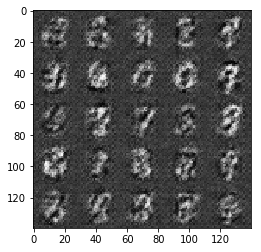

Epoch: 0 - Discriminator Loss: 1.33281 ..... Generator Loss: 0.525863
Epoch: 0 - Discriminator Loss: 0.822106 ..... Generator Loss: 1.61699
Epoch: 0 - Discriminator Loss: 0.791485 ..... Generator Loss: 1.28185
Epoch: 0 - Discriminator Loss: 1.01179 ..... Generator Loss: 0.795277
Epoch: 0 - Discriminator Loss: 0.799428 ..... Generator Loss: 2.11086
Epoch: 0 - Discriminator Loss: 0.633903 ..... Generator Loss: 1.7427
Epoch: 0 - Discriminator Loss: 0.717308 ..... Generator Loss: 1.83775
Epoch: 0 - Discriminator Loss: 0.757057 ..... Generator Loss: 1.32381


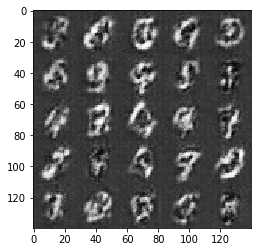

Epoch: 0 - Discriminator Loss: 0.641858 ..... Generator Loss: 2.06233
Epoch: 0 - Discriminator Loss: 0.708223 ..... Generator Loss: 1.43072
Epoch: 0 - Discriminator Loss: 0.808527 ..... Generator Loss: 1.0632
Epoch: 0 - Discriminator Loss: 1.20208 ..... Generator Loss: 0.610223
Epoch: 0 - Discriminator Loss: 0.682783 ..... Generator Loss: 1.69682
Epoch: 0 - Discriminator Loss: 0.642387 ..... Generator Loss: 1.70948
Epoch: 0 - Discriminator Loss: 0.697462 ..... Generator Loss: 1.35995
Epoch: 0 - Discriminator Loss: 0.706938 ..... Generator Loss: 1.33659


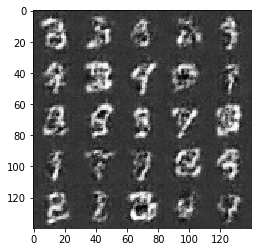

Epoch: 0 - Discriminator Loss: 0.969283 ..... Generator Loss: 0.859332
Epoch: 0 - Discriminator Loss: 0.930103 ..... Generator Loss: 0.88391
Epoch: 0 - Discriminator Loss: 0.627109 ..... Generator Loss: 1.53097
Epoch: 0 - Discriminator Loss: 0.563901 ..... Generator Loss: 1.81401
Epoch: 0 - Discriminator Loss: 0.715182 ..... Generator Loss: 1.27161
Epoch: 0 - Discriminator Loss: 0.874533 ..... Generator Loss: 0.949492
Epoch: 0 - Discriminator Loss: 1.12171 ..... Generator Loss: 0.668789
Epoch: 0 - Discriminator Loss: 0.746341 ..... Generator Loss: 1.34922


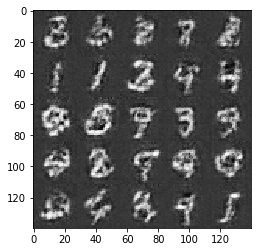

Epoch: 0 - Discriminator Loss: 0.673136 ..... Generator Loss: 1.40364
Epoch: 0 - Discriminator Loss: 0.595105 ..... Generator Loss: 2.35858
Epoch: 0 - Discriminator Loss: 0.667084 ..... Generator Loss: 1.43098
Epoch: 0 - Discriminator Loss: 1.78477 ..... Generator Loss: 0.315832
Epoch: 0 - Discriminator Loss: 0.663871 ..... Generator Loss: 1.40631
Epoch: 1 - Discriminator Loss: 0.696758 ..... Generator Loss: 1.6208
Epoch: 1 - Discriminator Loss: 0.730078 ..... Generator Loss: 1.2655
Epoch: 1 - Discriminator Loss: 0.940912 ..... Generator Loss: 0.854989


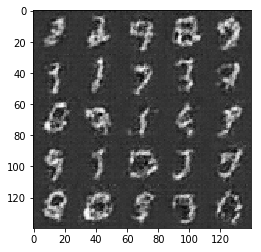

Epoch: 1 - Discriminator Loss: 0.776087 ..... Generator Loss: 1.13917
Epoch: 1 - Discriminator Loss: 0.816851 ..... Generator Loss: 1.05135
Epoch: 1 - Discriminator Loss: 0.767879 ..... Generator Loss: 1.15094
Epoch: 1 - Discriminator Loss: 0.695175 ..... Generator Loss: 1.3756
Epoch: 1 - Discriminator Loss: 0.503739 ..... Generator Loss: 2.22358
Epoch: 1 - Discriminator Loss: 1.68168 ..... Generator Loss: 0.364072
Epoch: 1 - Discriminator Loss: 0.533657 ..... Generator Loss: 1.94018
Epoch: 1 - Discriminator Loss: 0.596468 ..... Generator Loss: 1.59529


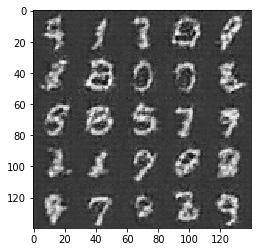

Epoch: 1 - Discriminator Loss: 0.646804 ..... Generator Loss: 1.55841
Epoch: 1 - Discriminator Loss: 0.84893 ..... Generator Loss: 1.02694
Epoch: 1 - Discriminator Loss: 0.795308 ..... Generator Loss: 1.13461
Epoch: 1 - Discriminator Loss: 1.02215 ..... Generator Loss: 0.77332
Epoch: 1 - Discriminator Loss: 0.696537 ..... Generator Loss: 1.31085
Epoch: 1 - Discriminator Loss: 0.618805 ..... Generator Loss: 1.59499
Epoch: 1 - Discriminator Loss: 0.640067 ..... Generator Loss: 1.61754
Epoch: 1 - Discriminator Loss: 0.576773 ..... Generator Loss: 1.88841


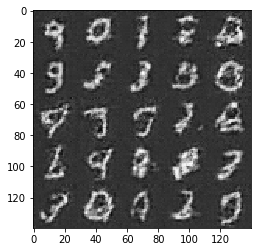

Epoch: 1 - Discriminator Loss: 0.637282 ..... Generator Loss: 1.55855
Epoch: 1 - Discriminator Loss: 1.17856 ..... Generator Loss: 0.627478
Epoch: 1 - Discriminator Loss: 0.739043 ..... Generator Loss: 1.20335
Epoch: 1 - Discriminator Loss: 0.708738 ..... Generator Loss: 1.26119
Epoch: 1 - Discriminator Loss: 1.60127 ..... Generator Loss: 0.410748
Epoch: 1 - Discriminator Loss: 1.00558 ..... Generator Loss: 0.780502
Epoch: 1 - Discriminator Loss: 0.69145 ..... Generator Loss: 1.32023
Epoch: 1 - Discriminator Loss: 0.541432 ..... Generator Loss: 1.92227


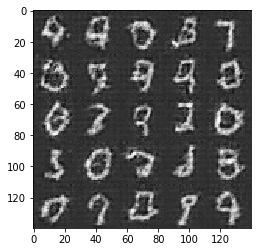

Epoch: 1 - Discriminator Loss: 1.01656 ..... Generator Loss: 0.787634
Epoch: 1 - Discriminator Loss: 0.491223 ..... Generator Loss: 2.18377
Epoch: 1 - Discriminator Loss: 0.719423 ..... Generator Loss: 1.25328
Epoch: 1 - Discriminator Loss: 0.632788 ..... Generator Loss: 1.49609
Epoch: 1 - Discriminator Loss: 0.567892 ..... Generator Loss: 1.72643
Epoch: 1 - Discriminator Loss: 0.535808 ..... Generator Loss: 2.03981
Epoch: 1 - Discriminator Loss: 0.523492 ..... Generator Loss: 1.96777
Epoch: 1 - Discriminator Loss: 0.554683 ..... Generator Loss: 1.78653


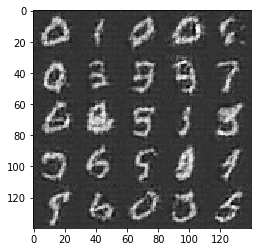

Epoch: 1 - Discriminator Loss: 0.589954 ..... Generator Loss: 1.58808
Epoch: 1 - Discriminator Loss: 1.0136 ..... Generator Loss: 0.794686


In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 - Discriminator Loss: 2.7156 ..... Generator Loss: 0.155259
Epoch: 0 - Discriminator Loss: 1.8617 ..... Generator Loss: 0.471474
Epoch: 0 - Discriminator Loss: 1.72814 ..... Generator Loss: 0.445822
Epoch: 0 - Discriminator Loss: 1.8213 ..... Generator Loss: 0.368416
Epoch: 0 - Discriminator Loss: 1.69724 ..... Generator Loss: 0.514584
Epoch: 0 - Discriminator Loss: 1.99157 ..... Generator Loss: 0.36664
Epoch: 0 - Discriminator Loss: 1.68542 ..... Generator Loss: 0.559129
Epoch: 0 - Discriminator Loss: 1.4786 ..... Generator Loss: 0.715114


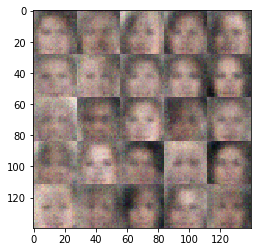

Epoch: 0 - Discriminator Loss: 1.63237 ..... Generator Loss: 0.574472
Epoch: 0 - Discriminator Loss: 1.43616 ..... Generator Loss: 0.72905
Epoch: 0 - Discriminator Loss: 1.48598 ..... Generator Loss: 0.787409
Epoch: 0 - Discriminator Loss: 1.66839 ..... Generator Loss: 0.56452
Epoch: 0 - Discriminator Loss: 1.42003 ..... Generator Loss: 0.746779
Epoch: 0 - Discriminator Loss: 1.49953 ..... Generator Loss: 0.727168
Epoch: 0 - Discriminator Loss: 1.51999 ..... Generator Loss: 0.615568
Epoch: 0 - Discriminator Loss: 1.51041 ..... Generator Loss: 0.783491


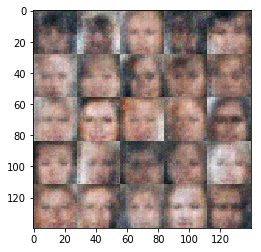

Epoch: 0 - Discriminator Loss: 1.58569 ..... Generator Loss: 0.668776
Epoch: 0 - Discriminator Loss: 1.53903 ..... Generator Loss: 0.636391
Epoch: 0 - Discriminator Loss: 1.49385 ..... Generator Loss: 0.599449
Epoch: 0 - Discriminator Loss: 1.43289 ..... Generator Loss: 0.655486
Epoch: 0 - Discriminator Loss: 1.4783 ..... Generator Loss: 0.670856
Epoch: 0 - Discriminator Loss: 1.46912 ..... Generator Loss: 0.687813
Epoch: 0 - Discriminator Loss: 1.3604 ..... Generator Loss: 0.85894
Epoch: 0 - Discriminator Loss: 1.44275 ..... Generator Loss: 0.724195


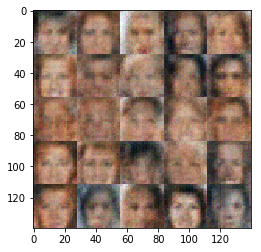

Epoch: 0 - Discriminator Loss: 1.43485 ..... Generator Loss: 0.745785
Epoch: 0 - Discriminator Loss: 1.4292 ..... Generator Loss: 0.728806
Epoch: 0 - Discriminator Loss: 1.36196 ..... Generator Loss: 0.867165
Epoch: 0 - Discriminator Loss: 1.44959 ..... Generator Loss: 0.743077
Epoch: 0 - Discriminator Loss: 1.37965 ..... Generator Loss: 0.940871
Epoch: 0 - Discriminator Loss: 1.43372 ..... Generator Loss: 0.793213
Epoch: 0 - Discriminator Loss: 1.60899 ..... Generator Loss: 0.447109
Epoch: 0 - Discriminator Loss: 1.15849 ..... Generator Loss: 1.21672


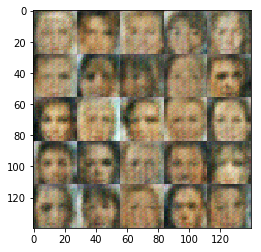

Epoch: 0 - Discriminator Loss: 1.20554 ..... Generator Loss: 0.653678
Epoch: 0 - Discriminator Loss: 1.25015 ..... Generator Loss: 1.27836
Epoch: 0 - Discriminator Loss: 1.05924 ..... Generator Loss: 0.742985
Epoch: 0 - Discriminator Loss: 0.777412 ..... Generator Loss: 2.59964
Epoch: 0 - Discriminator Loss: 0.685655 ..... Generator Loss: 4.10876
Epoch: 0 - Discriminator Loss: 1.92346 ..... Generator Loss: 0.261366
Epoch: 0 - Discriminator Loss: 1.01642 ..... Generator Loss: 3.51051
Epoch: 0 - Discriminator Loss: 1.48462 ..... Generator Loss: 0.565723


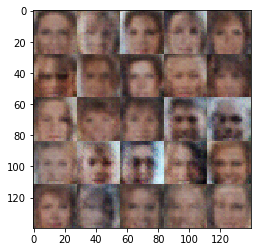

Epoch: 0 - Discriminator Loss: 1.8767 ..... Generator Loss: 0.319803
Epoch: 0 - Discriminator Loss: 1.44386 ..... Generator Loss: 0.725343
Epoch: 0 - Discriminator Loss: 1.51508 ..... Generator Loss: 0.723913
Epoch: 0 - Discriminator Loss: 1.62362 ..... Generator Loss: 0.453206
Epoch: 0 - Discriminator Loss: 1.40953 ..... Generator Loss: 0.899023
Epoch: 0 - Discriminator Loss: 1.5067 ..... Generator Loss: 0.624371
Epoch: 0 - Discriminator Loss: 1.48689 ..... Generator Loss: 0.549945
Epoch: 0 - Discriminator Loss: 0.875192 ..... Generator Loss: 2.06384


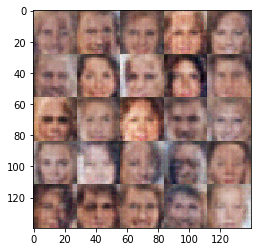

Epoch: 0 - Discriminator Loss: 1.41376 ..... Generator Loss: 0.485114
Epoch: 0 - Discriminator Loss: 1.40151 ..... Generator Loss: 0.518646
Epoch: 0 - Discriminator Loss: 1.1212 ..... Generator Loss: 2.01598
Epoch: 0 - Discriminator Loss: 0.581449 ..... Generator Loss: 2.34486
Epoch: 0 - Discriminator Loss: 0.719564 ..... Generator Loss: 1.65204
Epoch: 0 - Discriminator Loss: 0.878022 ..... Generator Loss: 3.56799
Epoch: 0 - Discriminator Loss: 0.770953 ..... Generator Loss: 1.57482
Epoch: 0 - Discriminator Loss: 0.967039 ..... Generator Loss: 4.0369


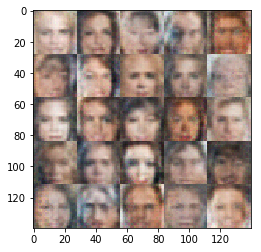

Epoch: 0 - Discriminator Loss: 2.10869 ..... Generator Loss: 0.200354
Epoch: 0 - Discriminator Loss: 1.9672 ..... Generator Loss: 0.233556
Epoch: 0 - Discriminator Loss: 0.504073 ..... Generator Loss: 5.64136
Epoch: 0 - Discriminator Loss: 0.506021 ..... Generator Loss: 3.38393
Epoch: 0 - Discriminator Loss: 0.940457 ..... Generator Loss: 0.928711
Epoch: 0 - Discriminator Loss: 0.730335 ..... Generator Loss: 10.3519
Epoch: 0 - Discriminator Loss: 1.53246 ..... Generator Loss: 0.380807
Epoch: 0 - Discriminator Loss: 0.366328 ..... Generator Loss: 7.5357


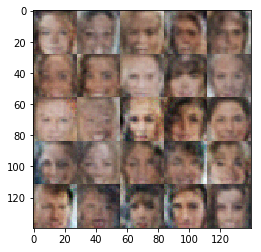

Epoch: 0 - Discriminator Loss: 0.378482 ..... Generator Loss: 3.70951
Epoch: 0 - Discriminator Loss: 0.387575 ..... Generator Loss: 3.84682
Epoch: 0 - Discriminator Loss: 0.499161 ..... Generator Loss: 2.22136
Epoch: 0 - Discriminator Loss: 1.13396 ..... Generator Loss: 4.60677
Epoch: 0 - Discriminator Loss: 1.69563 ..... Generator Loss: 0.321817
Epoch: 0 - Discriminator Loss: 0.398754 ..... Generator Loss: 2.98834
Epoch: 0 - Discriminator Loss: 1.81131 ..... Generator Loss: 4.18844
Epoch: 0 - Discriminator Loss: 0.558255 ..... Generator Loss: 1.777


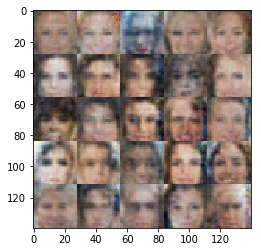

Epoch: 0 - Discriminator Loss: 0.622334 ..... Generator Loss: 2.48023
Epoch: 0 - Discriminator Loss: 0.434988 ..... Generator Loss: 4.24067
Epoch: 0 - Discriminator Loss: 0.352516 ..... Generator Loss: 5.50214
Epoch: 0 - Discriminator Loss: 0.39379 ..... Generator Loss: 3.15364
Epoch: 0 - Discriminator Loss: 0.634075 ..... Generator Loss: 1.51878
Epoch: 0 - Discriminator Loss: 0.355549 ..... Generator Loss: 4.11565
Epoch: 0 - Discriminator Loss: 0.766838 ..... Generator Loss: 1.15255
Epoch: 0 - Discriminator Loss: 0.39607 ..... Generator Loss: 6.40121


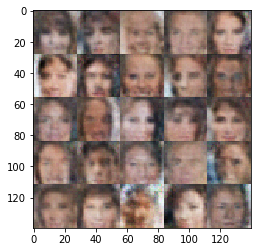

Epoch: 0 - Discriminator Loss: 0.367691 ..... Generator Loss: 5.22886
Epoch: 0 - Discriminator Loss: 0.584555 ..... Generator Loss: 1.87665
Epoch: 0 - Discriminator Loss: 0.359771 ..... Generator Loss: 4.16121
Epoch: 0 - Discriminator Loss: 0.339223 ..... Generator Loss: 7.55549
Epoch: 0 - Discriminator Loss: 0.346331 ..... Generator Loss: 7.59552
Epoch: 0 - Discriminator Loss: 0.344862 ..... Generator Loss: 4.95583
Epoch: 0 - Discriminator Loss: 0.529985 ..... Generator Loss: 10.5195
Epoch: 0 - Discriminator Loss: 0.884642 ..... Generator Loss: 0.945711


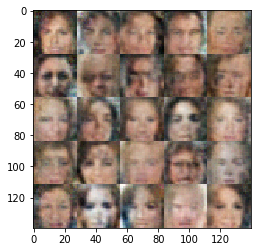

Epoch: 0 - Discriminator Loss: 0.354064 ..... Generator Loss: 5.18773
Epoch: 0 - Discriminator Loss: 0.444272 ..... Generator Loss: 5.04925
Epoch: 0 - Discriminator Loss: 0.342485 ..... Generator Loss: 10.4458
Epoch: 0 - Discriminator Loss: 0.338675 ..... Generator Loss: 5.81859
Epoch: 0 - Discriminator Loss: 0.405168 ..... Generator Loss: 2.95625
Epoch: 0 - Discriminator Loss: 0.333726 ..... Generator Loss: 9.45424
Epoch: 0 - Discriminator Loss: 0.335654 ..... Generator Loss: 8.21054
Epoch: 0 - Discriminator Loss: 0.380946 ..... Generator Loss: 5.06515


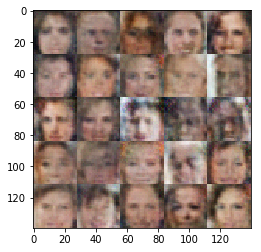

Epoch: 0 - Discriminator Loss: 0.690251 ..... Generator Loss: 1.33404
Epoch: 0 - Discriminator Loss: 0.347865 ..... Generator Loss: 4.79111
Epoch: 0 - Discriminator Loss: 0.345171 ..... Generator Loss: 5.14971
Epoch: 0 - Discriminator Loss: 0.338291 ..... Generator Loss: 11.5765
Epoch: 0 - Discriminator Loss: 0.335713 ..... Generator Loss: 8.13123
Epoch: 0 - Discriminator Loss: 0.88074 ..... Generator Loss: 0.943981
Epoch: 0 - Discriminator Loss: 0.398285 ..... Generator Loss: 3.26425
Epoch: 0 - Discriminator Loss: 1.26605 ..... Generator Loss: 0.630116


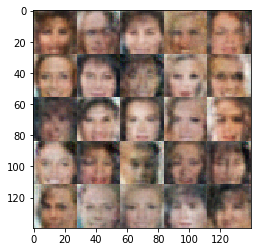

Epoch: 0 - Discriminator Loss: 0.3341 ..... Generator Loss: 7.74244
Epoch: 0 - Discriminator Loss: 0.407586 ..... Generator Loss: 2.91347
Epoch: 0 - Discriminator Loss: 0.360799 ..... Generator Loss: 4.43638
Epoch: 0 - Discriminator Loss: 0.334238 ..... Generator Loss: 9.83674
Epoch: 0 - Discriminator Loss: 0.334055 ..... Generator Loss: 8.46502
Epoch: 0 - Discriminator Loss: 0.344331 ..... Generator Loss: 5.4208
Epoch: 0 - Discriminator Loss: 0.357562 ..... Generator Loss: 5.01077
Epoch: 0 - Discriminator Loss: 0.664263 ..... Generator Loss: 1.52591


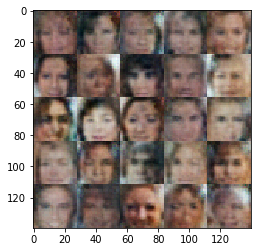

Epoch: 0 - Discriminator Loss: 0.379941 ..... Generator Loss: 5.12631
Epoch: 0 - Discriminator Loss: 0.338834 ..... Generator Loss: 5.2773
Epoch: 0 - Discriminator Loss: 0.540542 ..... Generator Loss: 5.29422
Epoch: 0 - Discriminator Loss: 0.463678 ..... Generator Loss: 6.23945
Epoch: 0 - Discriminator Loss: 1.58583 ..... Generator Loss: 0.414179
Epoch: 0 - Discriminator Loss: 0.486436 ..... Generator Loss: 2.12708
Epoch: 0 - Discriminator Loss: 0.380908 ..... Generator Loss: 3.53369
Epoch: 0 - Discriminator Loss: 0.354392 ..... Generator Loss: 7.68806


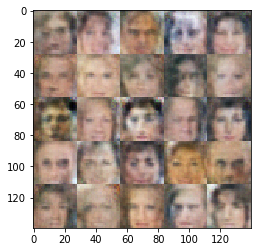

Epoch: 0 - Discriminator Loss: 0.332747 ..... Generator Loss: 7.42292
Epoch: 0 - Discriminator Loss: 0.356651 ..... Generator Loss: 4.51957
Epoch: 0 - Discriminator Loss: 0.988757 ..... Generator Loss: 8.91553
Epoch: 0 - Discriminator Loss: 0.563317 ..... Generator Loss: 4.87885
Epoch: 0 - Discriminator Loss: 1.50487 ..... Generator Loss: 0.451117
Epoch: 0 - Discriminator Loss: 0.426463 ..... Generator Loss: 11.4465


In [39]:
#batch_size = 32
#z_dim = 150
#learning_rate = 0.0002
#beta1 = 0.5

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.